<a href="https://colab.research.google.com/github/Sangeetha2998/Stock-price-prediction/blob/main/market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed

Epoch 1/100


35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - loss: 0.0351 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 0.0038 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - loss: 0.0032 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 0.0030 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 0.0031 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - loss: 0.0024 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - loss: 0.0026 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - loss: 0.0025 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - loss: 0.0026 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 10/10

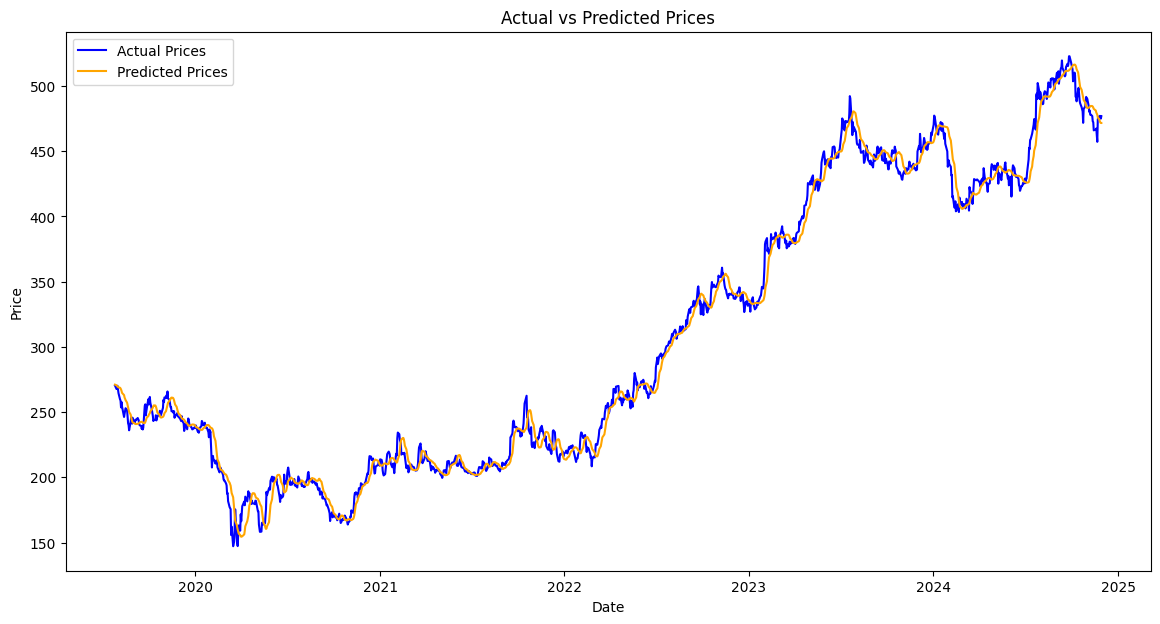

In [20]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Step 1: Data Acquisition
ticker = 'ITC.NS'  # Example stock ticker
data = yf.download(ticker, start='2019-01-01', end='2024-12-02', interval='1d')  # Daily data for 1 year

# Step 2: Data Preprocessing
data['Close'] = data['Close'].astype(float)

# Feature Engineering: Adding technical indicators
data['SMA'] = data['Close'].rolling(window=20).mean()  # Simple Moving Average
data['EMA'] = data['Close'].ewm(span=20, adjust=False).mean()  # Exponential Moving Average
data['Volume'] = data['Volume'].astype(float)  # Ensure Volume is float

# Drop rows with NaN values
data.dropna(inplace=True)

# Use only relevant features
data = data[['Close', 'SMA', 'EMA', 'Volume']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for LSTM and GRU
def create_sequences(data, time_steps=1):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps), :])  # Use all features
        y.append(data[i + time_steps, 0])  # Predicting the 'Close' price
    return np.array(x), np.array(y)

time_steps = 60  # Using the last 60 days for prediction
x, y = create_sequences(scaled_data, time_steps)
x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2]))

from keras.layers import Input

# Step 3: Model Building
model = Sequential()

# Adding Input layer and LSTM layers
model.add(Input(shape=(x.shape[1], x.shape[2])))  # Use Input layer
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# Adding GRU layers
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Predicting the next closing price
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 4: Model Training with Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Fit the model
model.fit(x, y, epochs=100, batch_size=32, verbose=1,
          validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Step 5: Prediction
# Prepare last 60 days for prediction
last_prices = scaled_data[-time_steps:]
last_prices = last_prices.reshape(1, -1, last_prices.shape[1])

predicted_prices = []
for _ in range(10):  # Predicting for the next 10 days
    predicted_price_scaled = model.predict(last_prices)

    # Create a temporary array to hold the predicted price and the other features
    temp_array = np.zeros((1, 1, last_prices.shape[2]))
    temp_array[0, 0, 0] = predicted_price_scaled[0, 0]  # Close price
    temp_array[0, 0, 1:] = last_prices[0, -1, 1:]  # Other features

    # Update last_prices for the next prediction
    last_prices = np.append(last_prices[:, 1:, :], temp_array, axis=1)

    # Inverse transform to get the actual price
    predicted_price = scaler.inverse_transform(temp_array[0])  # Get the actual price
    predicted_prices.append(predicted_price[0][0])  # Store the 'Close' price

# Print predicted prices for the next 10 days
print("Predicted prices for the next 10 days:", predicted_prices)

# Step 6: Model Evaluation
# Prepare the test set
x_eval, y_eval = create_sequences(scaled_data[-(len(data) - time_steps):], time_steps)
x_eval = np.reshape(x_eval, (x_eval.shape[0], x_eval.shape[1], x_eval.shape[2]))

# Predictions on the evaluation set
y_pred = model.predict(x_eval)
# Step 6: Model Evaluation (continued)
y_pred_inverse = scaler.inverse_transform(np.concatenate((y_pred, x_eval[:, -1, 1:].reshape(-1, x_eval.shape[2] - 1)), axis=1))

# Calculate evaluation metrics
mse = mean_squared_error(y_eval, y_pred_inverse[:, 0])
mae = mean_absolute_error(y_eval, y_pred_inverse[:, 0])

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

# Optional: Plotting the results for visual inspection
import matplotlib.pyplot as plt

# Plotting the actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_eval):], data['Close'].values[-len(y_eval):], label='Actual Prices', color='blue')
plt.plot(data.index[-len(y_eval):], y_pred_inverse[:, 0], label='Predicted Prices', color='orange')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

